In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from viz import plot_opinions_over_time, plot_campaign_budgets_with_order
from algos import (
    compute_expected_value_for_budget_distribution,
    dynamic_programming_with_grid,
    forward_propagation_with_grid,
)
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [3]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix


def init_env():
    links = [
        (1, 3),
        (3, 2),
        (2, 3),
        (2, 0),
        (0, 2),
        (1, 2),
        (0, 1),
    ]

    num_nodes = 4
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0.7, 0, num_nodes)
    # initial_opinions = np.linspace(0, 1, num_nodes)
    # initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.5,
        budget=1000.0,
        desired_opinion=0.9,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

[0.7        0.46666667 0.23333333 0.        ]


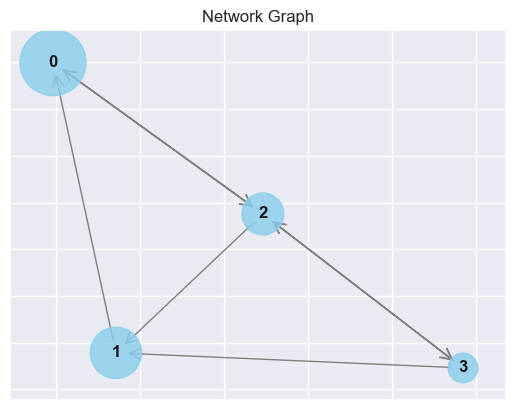

In [4]:
env = init_env()
print(env.opinions)
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


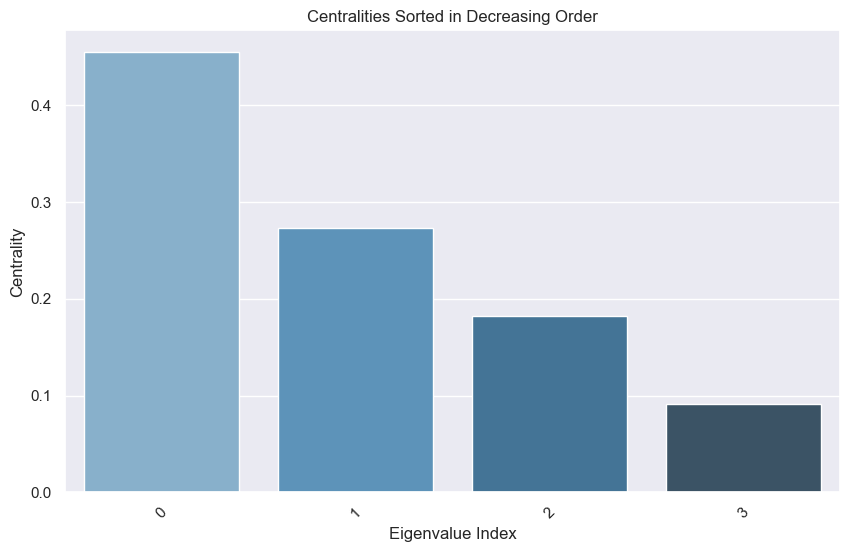

In [5]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.4204647904080085
Final Error: 0.4120701748735516


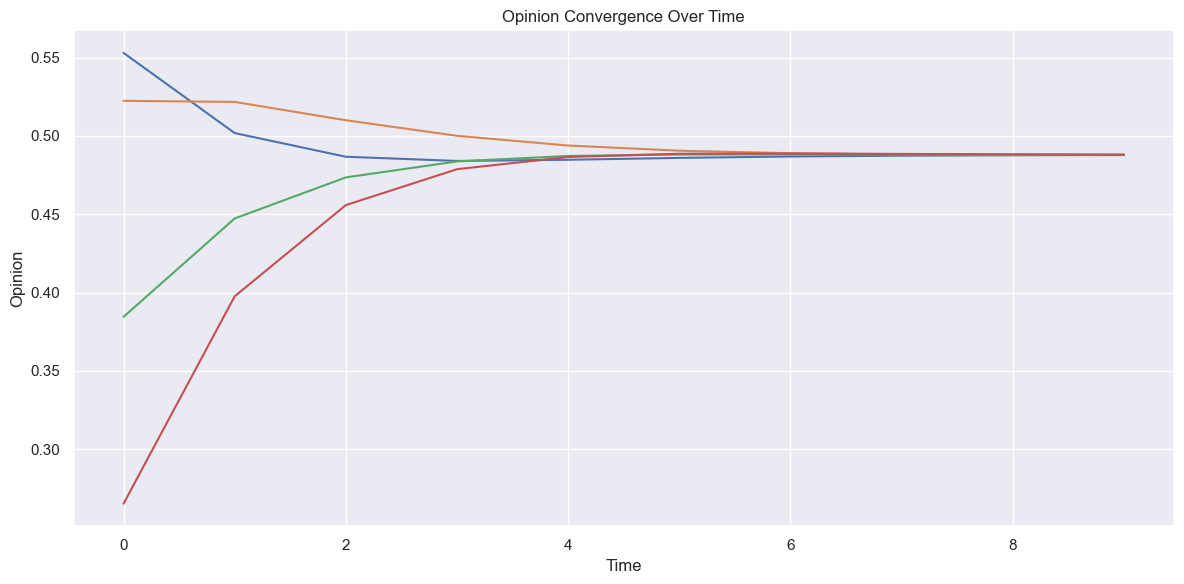

In [6]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

Overall Error: 0.21023239520400425
Final Error: 0.2060350874367758


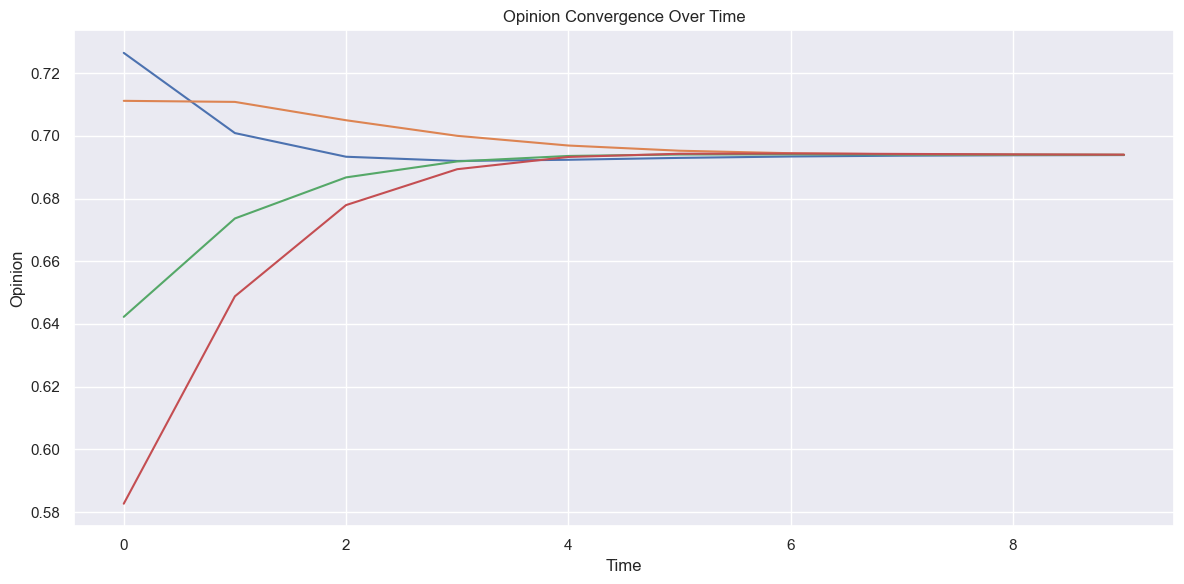

In [7]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    if i == 0:
        action_u = np.ones(env.num_agents) * env.max_u
        opinions, reward, done, truncated, info = env.step(action_u)
        opinions_over_time[i] = opinions
    else:
        no_action_u = np.zeros(env.num_agents)  # Zero control input
        opinions, reward, done, truncated, info = env.step(no_action_u)
        opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

### Baseline 

Simulation stopped after 6 campaigns.

Policy Strategy - Overall Error: 0.07207116206425851
Final Error: 0.00643939393939591


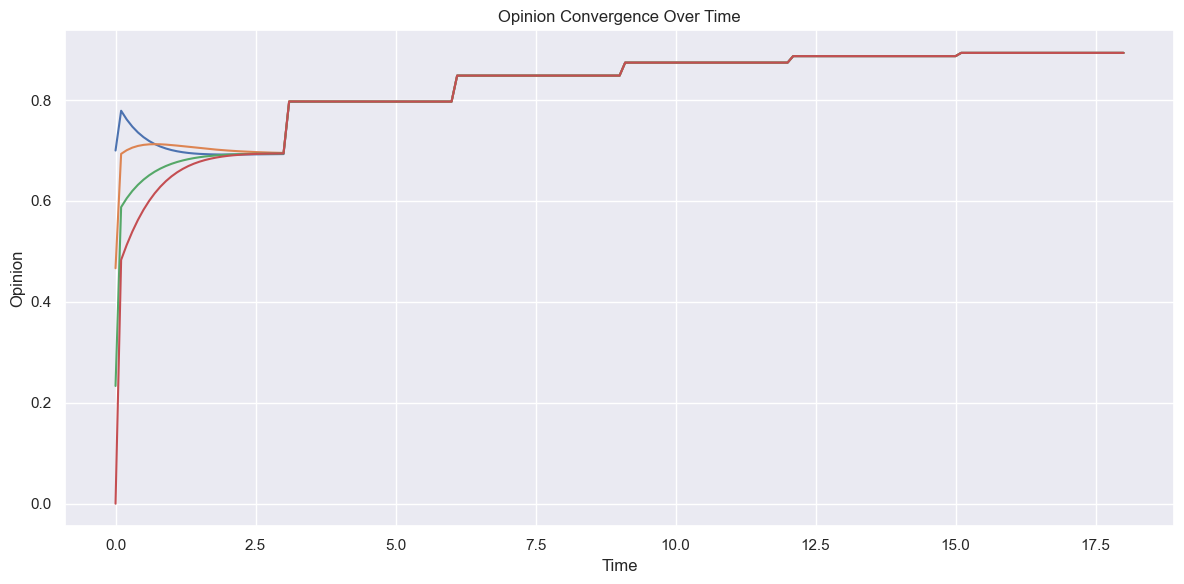

In [8]:
from algos import run_policy_campaigns, generate_full_control_policy


# Assuming create_state_grid and other necessary functions are defined
# Example Usage
env = init_env()
step_duration = 3  # Duration of each campaign
sampling_time = 0.1  # Sampling interval during each campaign
tolerance = 0.01  # Stopping criterion for mean opinion
nx = 5  # Number of grid points per dimension
max_campaigns = 100

# Compute the policy using value iteration
policy_broadcast = generate_full_control_policy(env, nx)

# Run the campaigns using the policy
opinions_over_time, time_points, nodes_controlled_simulation = run_policy_campaigns(
    env, policy_broadcast, nx, step_duration, sampling_time, tolerance, max_campaigns
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"\nPolicy Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot the opinions over time (ensure you have the plotting function defined)
plot_opinions_over_time(opinions_over_time, time_points)

In [9]:
# viz: per node, one axis mean of network, one axis opinion in node, represent taken action

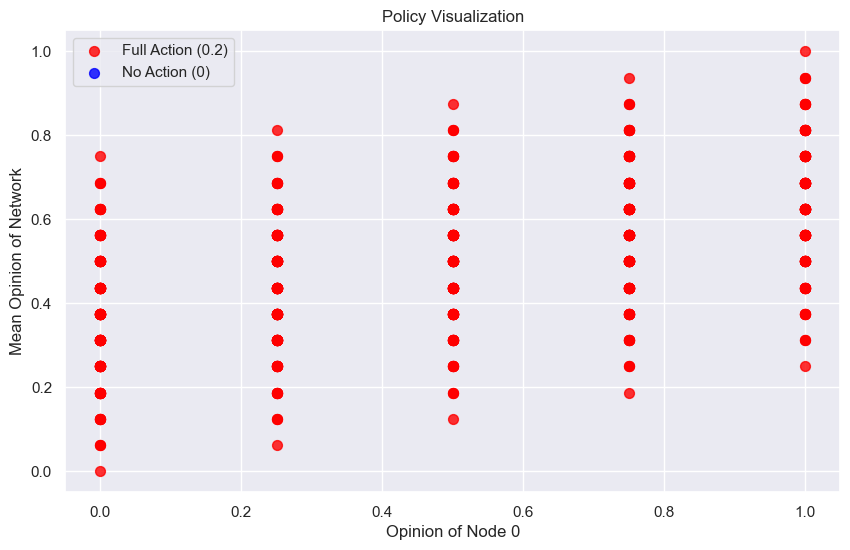

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_policy_from_env(policy, env, nx, node_index):
    """
    Visualize the policy with respect to the value of a specific node and mean opinion of the network.

    Args:
        policy (dict): Mapping from state indices to actions.
        env: The environment with network properties.
        nx (int): Number of grid points per dimension.
        node_index (int): The index of the node to visualize.
    """
    # Define the state grid: opinions range from 0 to 1
    N = env.num_agents  # Number of agents
    grids = [np.linspace(0, 1, nx) for _ in range(N)]  # Uniform grid in [0, 1]

    node_opinions = []  # X-axis: Opinion of the specific node
    mean_opinions = []  # Y-axis: Mean opinion of the network
    actions = []  # Full action (0.2) or no action (0)

    for idx, action in policy.items():
        # Map state indices to grid values
        state = [grids[i][idx[i]] for i in range(N)]
        node_opinion = state[node_index]  # Opinion of the specific node
        mean_opinion = np.mean(state)  # Mean opinion of the network

        node_opinions.append(node_opinion)
        mean_opinions.append(mean_opinion)
        actions.append(np.any(action))  # 1 if full action (0.2), 0 if no action

    # Map actions to two colors
    colors = ["red" if a else "blue" for a in actions]

    # Scatter plot
    plt.figure(figsize=(10, 6))
    for color, label in zip(["red", "blue"], ["Full Action (0.2)", "No Action (0)"]):
        subset_idx = [i for i, c in enumerate(colors) if c == color]
        plt.scatter(
            np.array(node_opinions)[subset_idx],
            np.array(mean_opinions)[subset_idx],
            c=color,
            label=label,
            s=50,
            alpha=0.8,
        )

    plt.xlabel(f"Opinion of Node {node_index}")
    plt.ylabel("Mean Opinion of Network")
    plt.title("Policy Visualization")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage:
# Assuming `policy` is created by `generate_full_control_policy` and `env` is initialized.
node_index = 0  # Choose a node to visualize
visualize_policy_from_env(policy_broadcast, env, nx=5, node_index=node_index)

### Infinite horizon

In [11]:
import numpy as np
from itertools import product
from scipy.linalg import expm
from scipy.interpolate import RegularGridInterpolator


def create_state_grid(N, nx):
    grid_range = np.linspace(0, 1, nx)
    grids = [grid_range for _ in range(N)]
    return grids


def initialize_value_function(N, nx):
    grid_shape = tuple([nx] * N)
    return np.zeros(grid_shape)


def reward_function(x, u, d, beta):
    return -np.abs(d - x).sum() - beta * np.sum(u)


def build_interpolator(V, grids):
    """
    Build a global interpolator for the current value function V.
    """
    return RegularGridInterpolator(grids, V, bounds_error=False, fill_value=None)


def value_iteration(
    env, nx=10, gamma=1.0, beta=0.0, step_duration=3.0, max_iterations=1000, tol=1e-6
):
    N = env.num_agents
    ubar = env.max_u
    d = env.desired_opinion

    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)

    V = initialize_value_function(N, nx)

    control_actions = list(product([0, ubar], repeat=N))

    for iteration in range(max_iterations):
        V_new = np.zeros_like(V)
        max_diff = 0

        interpolator = build_interpolator(V, grids)

        for idx in np.ndindex(grid_shape):
            current_state = np.array([grids[i][idx[i]] for i in range(N)])
            best_value = -np.inf

            for control in control_actions:
                control_input = np.array(control)
                next_state = env.compute_dynamics(
                    current_state, control_input, step_duration
                )
                next_state = np.clip(next_state, 0, 1)

                # next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))
                # future_value = V[next_idx]
                future_value = interpolator(next_state)

                immediate_reward = reward_function(
                    current_state, control_input, d, beta
                )

                total_value = immediate_reward + gamma * future_value
                if total_value > best_value:
                    best_value = total_value

            V_new[idx] = best_value
            max_diff = max(max_diff, abs(V_new[idx] - V[idx]))

        if max_diff < tol:
            print(f"Converged in {iteration + 1} iterations.")
            break

        V = V_new

    return V


def extract_policy(env, V, nx=10, gamma=1.0, beta=0.0, step_duration=3.0):
    N = env.num_agents
    ubar = env.max_u
    d = env.desired_opinion

    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)

    control_actions = list(product([0, ubar], repeat=N))
    policy = {}

    interpolator = build_interpolator(V, grids)

    for idx in np.ndindex(grid_shape):
        current_state = np.array([grids[i][idx[i]] for i in range(N)])
        best_value = -np.inf
        best_action = None

        for control in control_actions:
            control_input = np.array(control)
            next_state = env.compute_dynamics(
                current_state, control_input, step_duration
            )
            next_state = np.clip(next_state, 0, 1)

            # next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))
            # future_value = V[next_idx]
            future_value = interpolator(next_state)

            immediate_reward = reward_function(current_state, control_input, d, beta)
            total_value = immediate_reward + gamma * future_value

            if total_value > best_value:
                best_value = total_value
                best_action = control_input

        policy[idx] = best_action if best_action is not None else np.zeros(N)

    return policy


# Adjusted parameters
beta = 0.4
gamma = 0.9
step_duration = 3
nx = 5  # Increased grid resolution

env = init_env()
# Run value iteration and extract policy
V = value_iteration(env, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)
policy = extract_policy(
    env, V, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration
)

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_22520\3643685972.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V_new[idx] = best_value


Converged in 124 iterations.


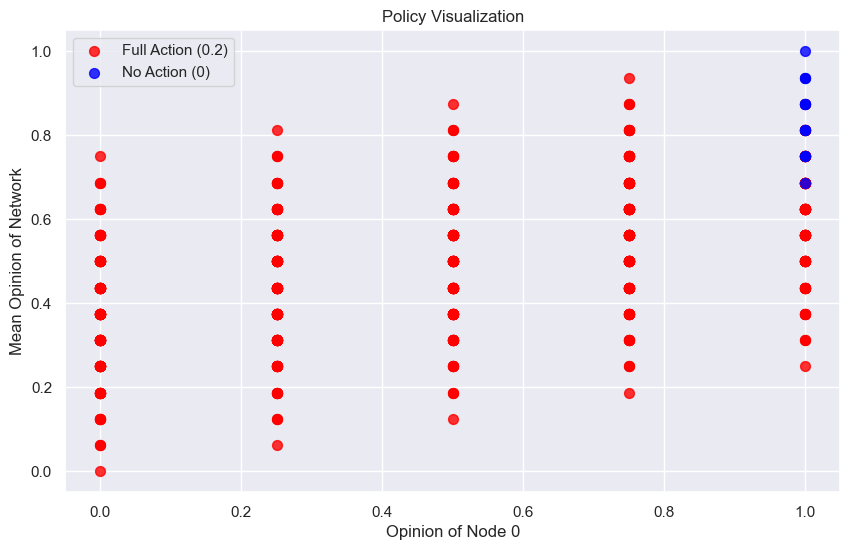

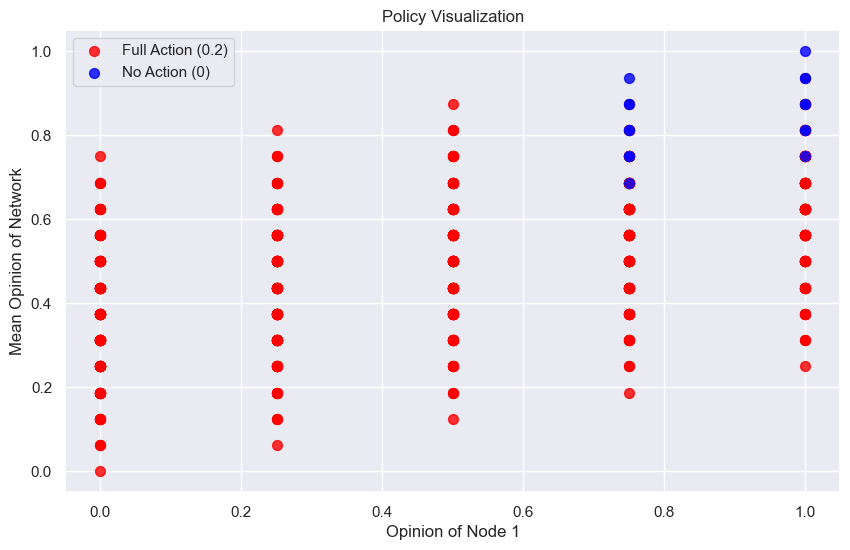

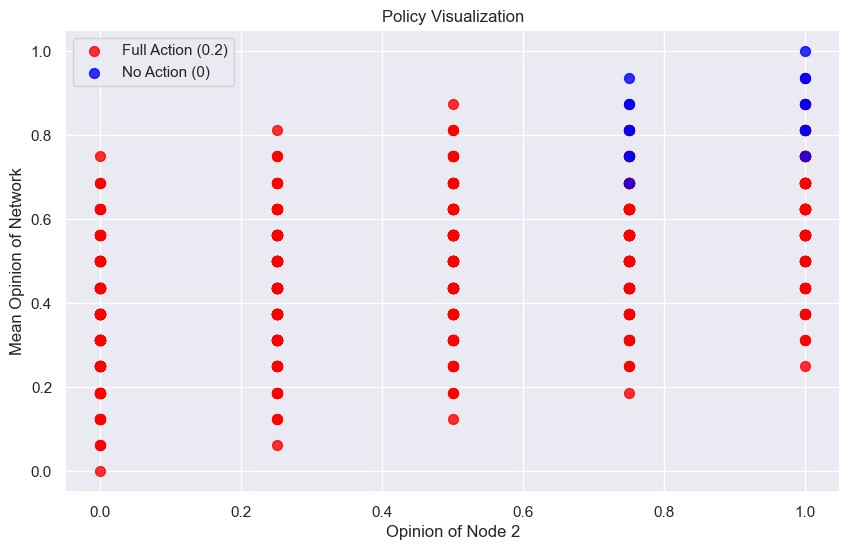

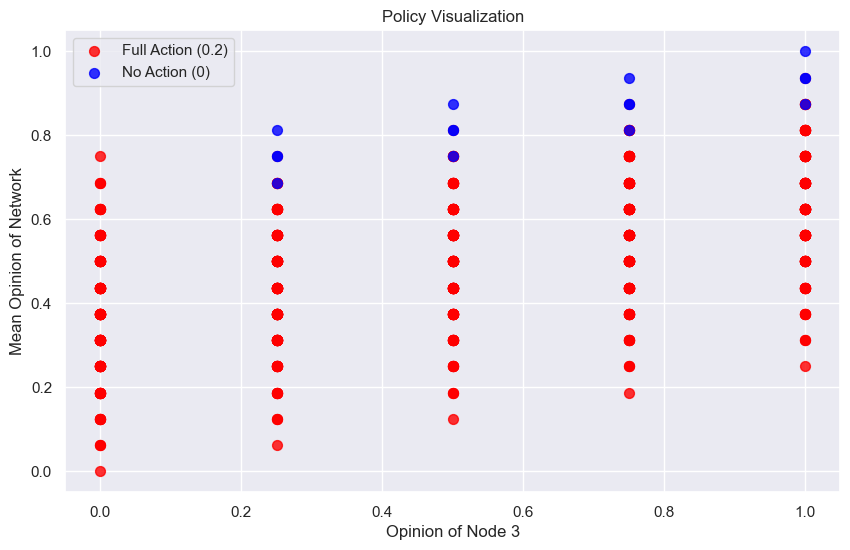

In [12]:
for node_index in range(env.num_agents):
    visualize_policy_from_env(policy, env, nx=nx, node_index=node_index)

Maximum number of campaigns reached.
Simulation stopped after 12 campaigns.

Policy Strategy - Overall Error: 0.07681727410283547
Final Error: 0.020193410248271454


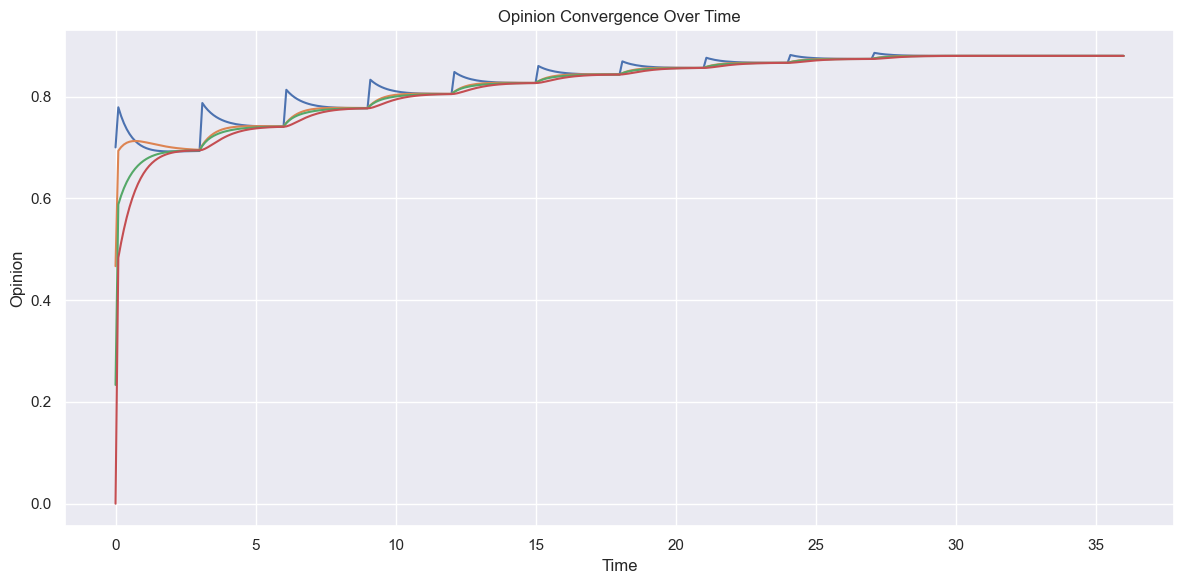

In [13]:
# Run the campaigns using the policy
opinions_over_time, time_points, nodes_controlled_simulation = run_policy_campaigns(
    env, policy, nx, step_duration, sampling_time, tolerance, max_campaigns=12
)

# Compute error
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"\nPolicy Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot the opinions over time (ensure you have the plotting function defined)
plot_opinions_over_time(opinions_over_time, time_points)

In [19]:
def evaluate_policy(env, policy, nx=10, gamma=0.9, beta=0.4, step_duration=3.0, max_iterations=1000, tol=1e-6):
    """
    Evaluate a given policy on the discretized state space.
    
    Arguments
    ---------
    env: Environment object with methods/attributes used below:
         - env.num_agents (int)
         - env.max_u (float)
         - env.desired_opinion (np.array of shape (N,))
         - env.compute_dynamics(state, action, step_duration) -> next_state
    policy: dict
        A dictionary mapping grid indices (like (i1, i2, ... iN)) to actions (np.array) 
        as returned by extract_policy().
    nx: int
        Number of discretization points along each dimension (same nx used in extract_policy).
    gamma: float
        Discount factor.
    beta: float
        Parameter in the reward function.
    step_duration: float
        Duration of each step (campaign duration).
    max_iterations: int
        Maximum number of policy evaluation iterations.
    tol: float
        Convergence threshold.
    
    Returns
    -------
    V_pi: np.array, shape (nx, nx, ..., nx)  # (N times)
        The value function for the given policy, discretized over the same grid.
    """
    N = env.num_agents
    d = env.desired_opinion

    # Build the same discrete grid structure
    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)

    # Initialize the value function
    V_pi = np.zeros(grid_shape)

    for iteration in range(max_iterations):
        V_new = np.zeros_like(V_pi)
        max_diff = 0.0

        # For each discrete state index
        for idx in np.ndindex(grid_shape):
            current_state = np.array([grids[i][idx[i]] for i in range(N)])
            
            # The policy dictates the action
            action = policy[idx]  # e.g. np.array of shape (N,)

            # Compute next state via environment dynamics
            next_state = env.compute_dynamics(current_state, action, step_duration)
            next_state = np.clip(next_state, 0, 1)

            # Find the closest grid indices for next_state
            # One approach is to just do nearest-neighbor lookup:
            next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))
            
            immediate_reward = reward_function(current_state, action, d, beta)
            V_new[idx] = immediate_reward + gamma * V_pi[next_idx]

            max_diff = max(max_diff, abs(V_new[idx] - V_pi[idx]))

        V_pi = V_new
        if max_diff < tol:
            # Converged
            print(f"Policy evaluation converged in {iteration+1} iterations.")
            break

    return V_pi

def evaluate_policy_reward(env, policy, nx, step_duration, sampling_time,
                           gamma=0.9, beta=0.4, tolerance=0.01, max_campaigns=100):
    """
    Simulate the environment under a given policy and return a single scalar:
    the sum of discounted rewards.

    Arguments:
    ----------
    env : Environment object
        Must have:
            - env.num_agents
            - env.opinions (initial state)
            - env.desired_opinion
            - env.compute_dynamics(current_state, control_input, step_duration)
    policy : dict
        A dictionary mapping discrete grid indices to control actions.
    nx : int
        Number of grid points per dimension (used for mapping states to grid indices).
    step_duration : float
        Duration of each campaign (control application).
    sampling_time : float
        Time between samples within each campaign.
    gamma : float
        Discount factor for cumulative reward.
    beta : float
        Parameter in the reward function.
    tolerance : float
        If the mean opinion is within this tolerance of the desired opinion, stop early.
    max_campaigns : int
        Maximum number of campaigns to run before stopping.

    Returns:
    --------
    total_discounted_reward : float
        The single scalar discounted reward accumulated under the policy.
    """
    def reward_function(x, u, d, beta):
        # Same as used in value_iteration
        return -np.abs(d - x).sum() - beta * np.sum(u)

    # Copy initial state from environment
    N = env.num_agents
    current_state = env.opinions.copy()

    grids = create_state_grid(N, nx)
    campaign_count = 0
    discount = 1.0
    total_discounted_reward = 0.0

    while True:
        campaign_count += 1

        # Find nearest grid index for current_state
        idx = tuple(np.abs(grids[i] - current_state[i]).argmin() for i in range(N))

        # Lookup the control action from policy (default to zeros if not found)
        control_input = policy.get(idx, np.zeros(N))

        # Compute immediate reward for the *current* state and action
        immediate_reward = reward_function(current_state, control_input, env.desired_opinion, beta)
        total_discounted_reward += discount * immediate_reward

        # Run the campaign with sampling to get next state
        opinions_campaign, times_campaign = simulate_campaign_with_sampling(
            env, control_input, current_state, step_duration, sampling_time
        )

        # The final state from this campaign
        current_state = opinions_campaign[-1].copy()

        # Update discount
        discount *= gamma

        # Check if mean opinion is close enough to desired
        mean_opinion_error = np.abs(np.mean(current_state) - env.desired_opinion)
        if mean_opinion_error <= tolerance:
            break

        # Check campaign limit
        if campaign_count >= max_campaigns:
            print("Maximum number of campaigns reached.")
            break

    return total_discounted_reward

In [21]:
env = init_env()
V_pi = evaluate_policy(env, policy, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)
print("Value function for the extracted policy:\n", V_pi)

policy_reward = evaluate_policy_reward(env, policy, nx=nx, step_duration=step_duration,
                                       sampling_time=sampling_time, gamma=gamma, beta=beta,
                                       tolerance=0.01, max_campaigns=100)

print(f"Single scalar reward for this policy: {policy_reward}")

Policy evaluation converged in 131 iterations.
Value function for the extracted policy:
 [[[[-12.85999189 -12.60999189 -12.15999189 -11.90999189 -11.85999189]
   [-12.60999189 -12.35999189 -11.90999189 -11.65999189 -11.60999189]
   [-12.35999189 -12.10999189 -11.65999189 -11.40999189 -11.35999189]
   [-11.90999189 -11.65999189 -11.20999189 -10.95999189 -10.90999189]
   [-11.85999189 -11.60999189 -11.15999189 -10.90999189 -10.85999189]]

  [[-12.60999189 -12.35999189 -11.90999189 -11.65999189 -11.60999189]
   [-12.35999189 -12.10999189 -11.65999189 -11.40999189 -11.35999189]
   [-12.10999189 -11.85999189 -11.40999189 -11.15999189 -11.10999189]
   [-11.65999189 -11.40999189 -10.95999189 -10.70999189 -10.65999189]
   [-11.60999189 -11.35999189 -10.90999189 -10.65999189  -9.34999189]]

  [[-12.35999189 -12.10999189 -11.65999189 -11.40999189 -11.35999189]
   [-12.10999189 -11.85999189 -11.40999189 -11.15999189 -11.10999189]
   [-11.85999189 -11.60999189 -11.15999189 -10.90999189 -10.8599918

In [22]:
env = init_env()
V_pi_broadcast = evaluate_policy(env, policy_broadcast, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)
print("Value function for the broadcasted policy:\n", V_pi_broadcast)

policy_reward = evaluate_policy_reward(env, policy_broadcast, nx=nx, step_duration=step_duration,
                                       sampling_time=sampling_time, gamma=gamma, beta=beta,
                                       tolerance=0.01, max_campaigns=100)

print(f"Single scalar reward for this policy: {policy_reward}")


Policy evaluation converged in 136 iterations.
Value function for the broadcasted policy:
 [[[[-17.89999162 -17.64999162 -17.39999162 -17.14999162 -17.09999162]
   [-17.64999162 -17.39999162 -17.14999162 -16.89999162 -16.84999162]
   [-17.39999162 -17.14999162 -16.89999162 -16.64999162 -16.59999162]
   [-17.14999162 -16.89999162 -16.64999162 -16.39999162 -16.34999162]
   [-17.09999162 -16.84999162 -16.59999162 -16.34999162 -16.29999162]]

  [[-17.64999162 -17.39999162 -17.14999162 -16.89999162 -16.84999162]
   [-17.39999162 -17.14999162 -16.89999162 -16.64999162 -16.59999162]
   [-17.14999162 -16.89999162 -16.64999162 -16.39999162 -16.34999162]
   [-16.89999162 -16.64999162 -16.39999162 -16.14999162 -16.09999162]
   [-16.84999162 -16.59999162 -16.34999162 -16.09999162 -16.04999162]]

  [[-17.39999162 -17.14999162 -16.89999162 -16.64999162 -16.59999162]
   [-17.14999162 -16.89999162 -16.64999162 -16.39999162 -16.34999162]
   [-16.89999162 -16.64999162 -16.39999162 -16.14999162 -16.09999

### Brute force

In [17]:
# import numpy as np
# from itertools import product

# def brute_force_optimal_control(
#     env,
#     initial_state,
#     max_campaigns=12,
#     step_duration=3.0,
#     gamma=0.9,
#     beta=0.4
# ):
#     """
#     Exhaustively searches over all sequences of length `max_campaigns` (T) 
#     where each control is in {0, ubar} for each agent.
    
#     Arguments:
#     ----------
#     env: The environment object with:
#          - env.num_agents (int)
#          - env.max_u (float)
#          - env.desired_opinion (np.array of shape (N,))
#          - env.compute_dynamics(state, control, step_duration) -> next_state (N-dim array)
#     initial_state: np.array of shape (N,)
#     max_campaigns: int, number of time steps (campaigns)
#     step_duration: float, time step duration
#     gamma: float, discount factor
#     beta: float, penalty weight in the reward function
    
#     Returns:
#     --------
#     best_sequence: list of np.array, the best (optimal) sequence of control actions
#     best_reward: float, the maximum discounted reward achieved
#     """

#     N = env.num_agents
#     ubar = env.max_u
#     d = env.desired_opinion
    
#     # All possible control actions per time step: each agent either 0 or ubar
#     control_actions = list(product([0, ubar], repeat=N))
    
#     # We'll track the best result across all sequences
#     best_reward = -np.inf
#     best_sequence = None
    
#     # Enumerate every possible action sequence of length max_campaigns
#     # Each element is a tuple of length T, where each entry is an action vector (N-dim)
#     for action_sequence in product(control_actions, repeat=max_campaigns):
#         # Convert that sequence of tuples-of-scalars into an array-of-arrays
#         # For instance, action_sequence might be something like
#         # ((0,0,...), (ubar,0,...), ..., (0,ubar,...)) of length T
#         # We'll treat it as a list of np.array
#         action_sequence_np = [np.array(a) for a in action_sequence]
        
#         # Simulate the environment forward from the initial state
#         total_reward = 0.0
#         discount = 1.0
#         current_state = initial_state.copy()
        
#         for t, action in enumerate(action_sequence_np):
#             # immediate reward
#             immediate_reward = reward_function(current_state, action, d, beta)
#             total_reward += discount * immediate_reward
            
#             # compute next state
#             next_state = env.compute_dynamics(current_state, action, step_duration)
#             # clip to [0,1]
#             next_state = np.clip(next_state, 0, 1)
            
#             current_state = next_state
#             discount *= gamma  # discount factor for next step
        
#         # Check if this sequence is better
#         if total_reward > best_reward:
#             best_reward = total_reward
#             best_sequence = action_sequence_np
    
#     return best_sequence, best_reward

# # Initialize environment
# env = init_env()

# # Retrieve the initial state from the fresh env
# initial_state = env.opinions.copy()  # or simply env.opinions, depending on your usage

# # -- Brute force approach --
# best_sequence, best_reward = brute_force_optimal_control(
#     env=env,
#     initial_state=initial_state,    # use the fresh env's initial state
#     max_campaigns=12,
#     step_duration=step_duration,
#     gamma=gamma,
#     beta=beta
# )
# print(f"Brute Force best discounted reward: {best_reward}")

# # Simulate the brute force sequence to measure error
# opinions_brute_force = []
# curr_state = initial_state.copy()
# for action in best_sequence:
#     opinions_brute_force.append(curr_state)
#     next_state = env.compute_dynamics(curr_state, action, step_duration)
#     curr_state = np.clip(next_state, 0, 1)
# opinions_brute_force = np.array(opinions_brute_force)

# bf_overall_error = compute_average_error(opinions_brute_force, env.desired_opinion)
# bf_final_error = compute_final_average_error(opinions_brute_force, env.desired_opinion)

# print(f"Brute Force - Overall Error: {bf_overall_error}")
# print(f"Brute Force - Final Error: {bf_final_error}")

# # Compare DP-based policy and brute force results
# # You can directly compare dp_final_error vs bf_final_error, or the discounted reward.



In [18]:
raise NotImplementedError

NotImplementedError: 

In [ ]:
# results_sorted_by_error